# Анализ оттока клиентов

## Материалы:
[**Презентация**](https://disk.yandex.ru/i/dKQmCP2rIya7sQ)

**Цель:** определить признаки, влияющие на отток клиентов и выделить сегменты клиентов, которые склонны уходить из банка и дать рекоментации по работе с ними.

**План:**
1. Загрузка и описание данных.
2. Предобрботка данных:
   - анализ природы пропусков и их обработка;
   - проверка на явные и неявные дубликаты;
   - кодирование (для использования в анализе корреляции).
3. EDA:
   - анализ распределения признаков, в тч в разрезе оттока;
   - корреляционный анализ;
   - сравнение портретов клиентов, которые склонны и не склонны уходить из банка.
4. Проверка статистических гипотез, обосновать инструмент.
5. Подведение промежуточных итогов - выводы по результатам EDA, корреляционного анализа и гипотез, выделение признаков, влияющих на отток.
6. Сегментация (неузкие сегменты (от 500 клиентов на сегмент)).
7. Приоритизация сегментов.
8. Формирование рекомендаций (таргетированных) по работе с ними.

## Загрузка и описание данных

In [1]:
# импортируем все необходимые библиотеки
import pandas as pd
import seaborn as sns
import numpy as np
import math as mth
import matplotlib.pylab as plt
from scipy import stats as st
from IPython.display import display
from functools import reduce

In [2]:
# загрузим данные
try:
    df = pd.read_csv('https://code.s3.yandex.net/datasets/bank_scrooge.csv')
except:
    'FileNotFoundError'

In [3]:
display(df.head(10))
display(df.info())
df.isna().sum()

,USERID,score,city,gender,age,equity,balance,products,credit_card,last_activity,EST_SALARY,churn
0,183012,850.0,Рыбинск,Ж,25.0,1,59214.82,2,0,1,75719.14,1
1,146556,861.0,Рыбинск,Ж,37.0,5,850594.33,3,1,0,86621.77,0
2,120722,892.0,Рыбинск,Ж,30.0,0,NaN,1,1,1,107683.34,0
3,225363,866.0,Ярославль,Ж,51.0,5,1524746.26,2,0,1,174423.53,1
4,157978,730.0,Ярославль,М,34.0,5,174.00,1,1,0,67353.16,1
5,202305,856.0,Рыбинск,М,56.0,4,863687.24,3,1,0,156619.80,0
6,177259,807.0,Ярославль,Ж,39.0,3,405042.44,3,0,1,103838.32,0
7,218868,825.0,Ярославль,Ж,38.0,4,458145.40,2,1,1,68085.48,0
8,211686,923.0,Ярославль,М,54.0,5,1206337.87,2,1,0,155371.79,0
9,133130,906.0,Ярославль,Ж,67.0,0,NaN,1,0,1,238055.53,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   USERID         10000 non-null  int64  
 1   score          10000 non-null  float64
 2   city           10000 non-null  object 
 3   gender         10000 non-null  object 
 4   age            9974 non-null   float64
 5   equity         10000 non-null  int64  
 6   balance        7705 non-null   float64
 7   products       10000 non-null  int64  
 8   credit_card    10000 non-null  int64  
 9   last_activity  10000 non-null  int64  
 10  EST_SALARY     10000 non-null  float64
 11  churn          10000 non-null  int64  
dtypes: float64(4), int64(6), object(2)
memory usage: 937.6+ KB


None

USERID              0
score               0
city                0
gender              0
age                26
equity              0
balance          2295
products            0
credit_card         0
last_activity       0
EST_SALARY          0
churn               0
dtype: int64

**Вывод:** Изучив данные видим, что в столбцах `age` и `balance` пропущены данные. Необходимо привести названия столбцов к нижнему регистру. В столбцах `score` и `age` нужно замнить тип данных на целочисленный.

## Предобрботка данных

### Приведем названия столбцов к нижнему регистру

In [4]:
# приведем названия столбцов к нижнему регистру
df.columns = df.columns.str.lower()
# заменим название столбца 'userid'
df = df.rename(columns={'userid': 'user_id'})
df.columns

Index(['user_id', 'score', 'city', 'gender', 'age', 'equity', 'balance',
       'products', 'credit_card', 'last_activity', 'est_salary', 'churn'],
      dtype='object')

### Проанализируем пропуски и обработаем их

In [5]:
# создадим столбцы с признаками пропущенных значений столбцов `age` и `balance`
df['age_isna'] = df['age'].isna().astype('int')
df['balance_isna'] = df['balance'].isna().astype('int')
# посмотрим на матрицу корреляции признаков
df.corr()

,user_id,score,age,equity,balance,products,credit_card,last_activity,est_salary,churn,age_isna,balance_isna
user_id,1.000000,0.009804,0.017795,0.004599,0.006133,-0.004504,0.005674,-0.031029,-0.000369,-0.011928,0.034571,0.004125
score,0.009804,1.000000,-0.011814,0.064126,0.235812,-0.004115,-0.094732,-0.031179,0.163866,0.105962,0.005035,0.138871
age,0.017795,-0.011814,1.000000,0.020628,0.069745,0.017182,-0.123128,-0.008157,-0.039598,-0.049797,NaN,-0.028659
equity,0.004599,0.064126,0.020628,1.000000,0.164126,0.432069,-0.167506,-0.001970,-0.171974,0.270559,-0.032040,-0.709951
balance,0.006133,0.235812,0.069745,0.164126,1.000000,0.075684,-0.059253,0.025004,0.339622,0.085577,0.007686,NaN
products,-0.004504,-0.004115,0.017182,0.432069,0.075684,1.000000,-0.251390,0.037141,-0.118054,0.300964,-0.033751,-0.487512
credit_card,0.005674,-0.094732,-0.123128,-0.167506,-0.059253,-0.251390,1.000000,-0.033445,0.035556,-0.130790,0.009726,0.158334
last_activity,-0.031029,-0.031179,-0.008157,-0.001970,0.025004,0.037141,-0.033445,1.000000,0.003039,0.168767,0.025120,0.028362
est_salary,-0.000369,0.163866,-0.039598,-0.171974,0.339622,-0.118054,0.035556,0.003039,1.000000,0.001273,0.011252,0.307154
churn,-0.011928,0.105962,-0.049797,0.270559,0.085577,0.300964,-0.130790,0.168767,0.001273,1.000000,-0.018994,-0.249421


Проанализировав зависимость пропущенных значений, видим что в столбце `age` нет зависимости пропусков с другими признаками следовательно данные отсутствуют случайно и пропуск относятся к типу MAR.<br>
В столбце `balance` данные коррелируют с признаком колличества баллов собственности, следовательно пропуск относятся к типу MNAR и мы не можем их отбросить или заполнить одним значением.

In [6]:
# посчитаем какое количество составляют пропуски в столбце `age`
df['age'].isna().sum()/df.shape[0]

0.0026

Пропуски в столбце `age` составляют всего 0,26%, удалим их без потери качества данных.

In [7]:
# удалим пропуски в столбце age
df = df.dropna(subset=['age'])

In [8]:
# заменим тип данных в столбцах score и age на целочисленный
df['score'] = df['score'].astype('int')
df['age'] = df['age'].astype('int')

In [9]:
df.head()

,user_id,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn,age_isna,balance_isna
0,183012,850,Рыбинск,Ж,25,1,59214.82,2,0,1,75719.14,1,0,0
1,146556,861,Рыбинск,Ж,37,5,850594.33,3,1,0,86621.77,0,0,0
2,120722,892,Рыбинск,Ж,30,0,NaN,1,1,1,107683.34,0,0,1
3,225363,866,Ярославль,Ж,51,5,1524746.26,2,0,1,174423.53,1,0,0
4,157978,730,Ярославль,М,34,5,174.00,1,1,0,67353.16,1,0,0


### Проверим данные на явные и неявные дубликаты

In [10]:
# проверим явные дубликаты
df.duplicated().sum()

0

Явных дубликатов в данных нет.

In [11]:
# проверим неявные дубликаты
df[df.duplicated(subset=['user_id'], keep=False)].sort_values(by ='user_id')

,user_id,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn,age_isna,balance_isna
1893,116540,883,Рыбинск,Ж,55,1,362756.49,3,0,1,175920.48,1,0,0
7694,116540,887,Ярославль,Ж,38,0,NaN,1,0,1,119247.61,0,0,1
4866,117943,855,Рыбинск,Ж,32,6,1036832.93,4,1,1,107792.71,1,0,0
7542,117943,880,Ярославль,Ж,40,0,NaN,1,1,0,137718.93,0,0,1
5863,120258,908,Рыбинск,Ж,38,4,2213581.63,2,0,1,160327.77,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2302,220816,934,Рыбинск,Ж,74,5,1294285.39,3,1,0,95606.80,0,0,0
2597,226719,990,Ярославль,М,37,4,14648692.14,2,0,0,934412.61,1,0,0
4216,226719,903,Рыбинск,Ж,63,0,NaN,1,1,0,138582.58,0,0,1
8205,227795,840,Рыбинск,М,34,2,350768.03,1,1,0,102036.14,1,0,0


Видим что у нас 100 дубликатов по столбцу `user_id`, а в столбцах `city`, `gender`, `age` соверешненно разные значения. Поэтому скорее всего произошел какой-то сбой при присвоении `user_id` и это разные люди.

In [12]:
# проверим данные по признаку количество продуктов, т.к. клиент банка должен иметь хотябы один продукт
df.query('products == 0')

,user_id,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn,age_isna,balance_isna
8957,147837,962,Рыбинск,Ж,79,3,NaN,0,0,0,25063.96,1,0,1


In [13]:
# удалим данные о клиенте, который не имеет продуктов в этом банке
df = df.query('products != 0').reset_index(drop=True)

### Кодирование данных

In [14]:
df['city_dum'] = df['city']
df['gender_dum'] = df['gender']
df=pd.get_dummies(df, columns=['city_dum'], prefix='', prefix_sep='')
df=pd.get_dummies(df, columns=['gender_dum'], prefix='', prefix_sep='', drop_first= True)
df = df.rename(columns={'М': 'gender_dum'})
df.head()

,user_id,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn,age_isna,balance_isna,Ростов,Рыбинск,Ярославль,gender_dum
0,183012,850,Рыбинск,Ж,25,1,59214.82,2,0,1,75719.14,1,0,0,0,1,0,0
1,146556,861,Рыбинск,Ж,37,5,850594.33,3,1,0,86621.77,0,0,0,0,1,0,0
2,120722,892,Рыбинск,Ж,30,0,NaN,1,1,1,107683.34,0,0,1,0,1,0,0
3,225363,866,Ярославль,Ж,51,5,1524746.26,2,0,1,174423.53,1,0,0,0,0,1,0
4,157978,730,Ярославль,М,34,5,174.00,1,1,0,67353.16,1,0,0,0,0,1,1


**Вывод:** Предобработка данных проведена:
- откорректировали названия столбцов и типы данных
- удалили пропуски в столбце `age`, которые составили 0,26% от общего числа данных
- явных дубликатов в данных не обнаружили
- нашли 100 дубликатов по столбцу `user_id`, но данные в других столбцах отличаются

В целом, данные подготовлены к дальнейшему анализу.

## EDA

### Анализ оттока по возрасту

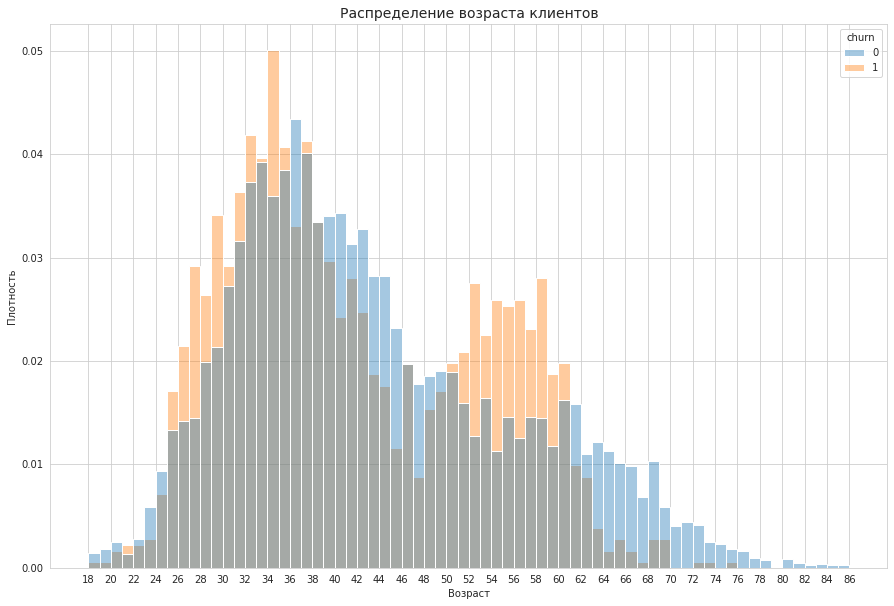

In [15]:
plt.figure(figsize=(15, 10))
sns.set_style('whitegrid')
sns.histplot(data=df, x='age', hue='churn', binwidth=1, stat='density', common_norm=False, alpha = 0.4)
plt.title('Распределение возраста клиентов', fontsize=14)
plt.xlabel('Возраст')
plt.ylabel('Плотность')
plt.xticks(np.arange(min(df['age']), max(df['age'])+1, 2.0))
plt.show()

По графику можем выделить две возрастные группы, когда отток клиентов большой:
- молодые люди 25-36 лет 
- взрослые люди, предпенсионного возраста 50-61 год

### Анализ оттока по баллу кредитного скоринга

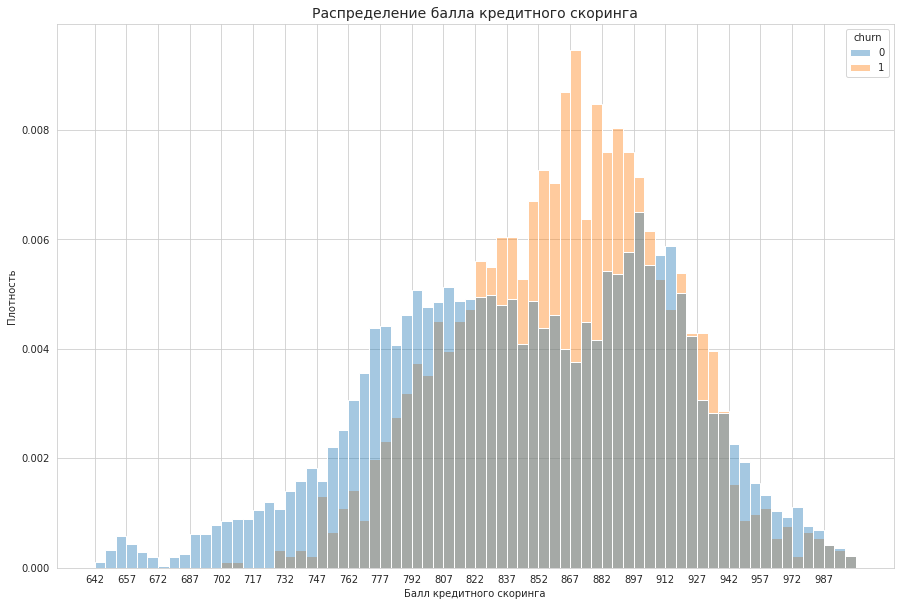

In [16]:
plt.figure(figsize=(15, 10))
sns.set_style('whitegrid')
sns.histplot(data=df, x='score', hue='churn', binwidth=5, stat='density', common_norm=False, alpha = 0.4)
plt.title('Распределение балла кредитного скоринга', fontsize=14)
plt.xlabel('Балл кредитного скоринга')
plt.ylabel('Плотность')
plt.xticks(np.arange(min(df['score']), max(df['score'])+1, 15.0))
plt.show()

Большой отток клиентов происходит в интервале значений скоринга 820-900, а ведь это скорее всего клиенты с хорошим доходом и хорошей кредитной историей.

### Анализ оттока по доходу клиента

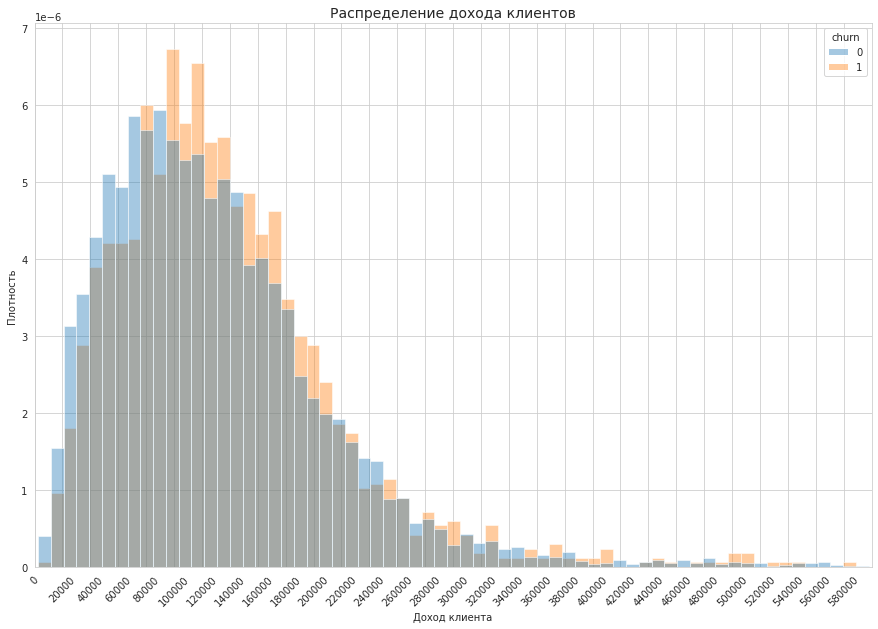

In [17]:
plt.figure(figsize=(15, 10))
sns.set_style('whitegrid')
sns.histplot(data=df, x='est_salary', hue='churn', stat='density', common_norm=False, alpha = 0.4)
plt.title('Распределение дохода клиентов', fontsize=14)
plt.xlabel('Доход клиента')
plt.ylabel('Плотность')
plt.xlim((0, 600000))
plt.xticks(np.arange(0, 600000, 20000.0), rotation=45)
plt.show()

Клиенты с доходом 90-210 тыс. наиболее отточны. Также по графику видно, что и клиенты с более высоким доходом склонны к оттоку больше, чем те чей доход до 90 тыс.

### Анализ оттока по балансу на счете

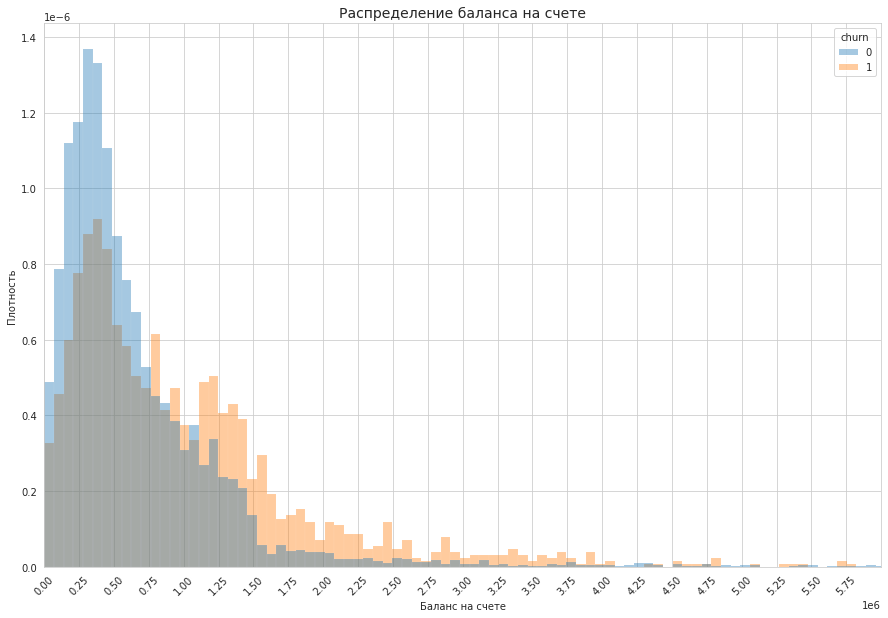

In [18]:
plt.figure(figsize=(15, 10))
sns.set_style('whitegrid')
sns.histplot(data=df, x='balance', hue='churn', stat='density', common_norm=False, alpha = 0.4)
plt.title('Распределение баланса на счете', fontsize=14)
plt.xlabel('Баланс на счете')
plt.ylabel('Плотность')
plt.xlim((0, 6000000))
plt.xticks(np.arange(0, 6000000, 250000.0), rotation=45)
plt.show()

Клиенты, которые имеют накопления на счёте больше 1 млн. склонны к оттоку. При этом чем сумма на сёте больше, тем больше и отток.

### Анализ оттока по городам

In [19]:
# рассчитаем средний уровень оттока по банку
mean_churn = df['churn'].mean()
mean_churn

0.18229218891005716

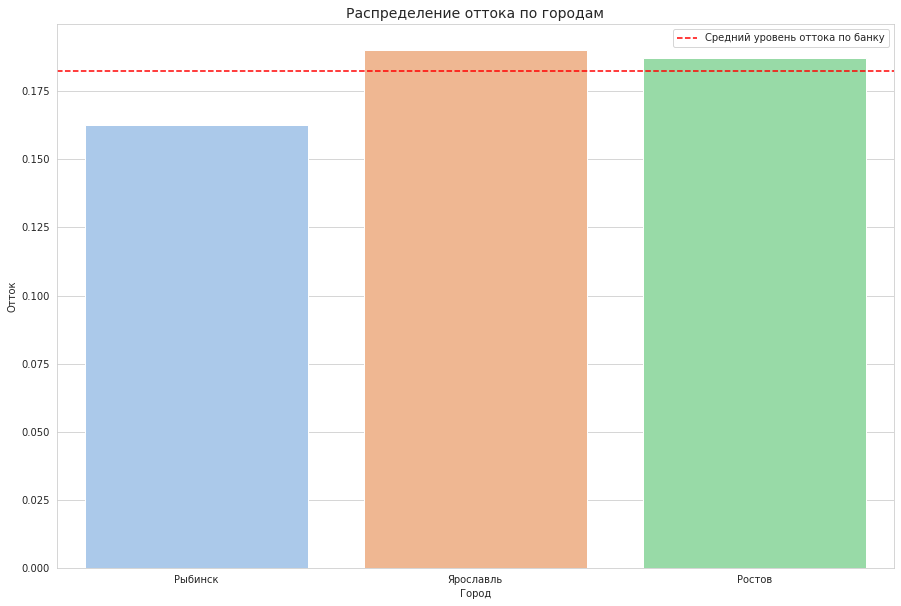

In [20]:
plt.figure(figsize=(15, 10))
sns.set_style('whitegrid')
sns.barplot(data=df, x='city', y='churn', ci=None, palette='pastel')
plt.axhline(y=mean_churn, color='red', linestyle='--', label='Cредний уровень оттока по банку')
plt.title('Распределение оттока по городам', fontsize=14)
plt.xlabel('Город')
plt.ylabel('Отток')
plt.legend()
plt.show()

В городах Ярославль и Ростов отток превышает средний отток по банку.

### Анализ оттока по половому признаку

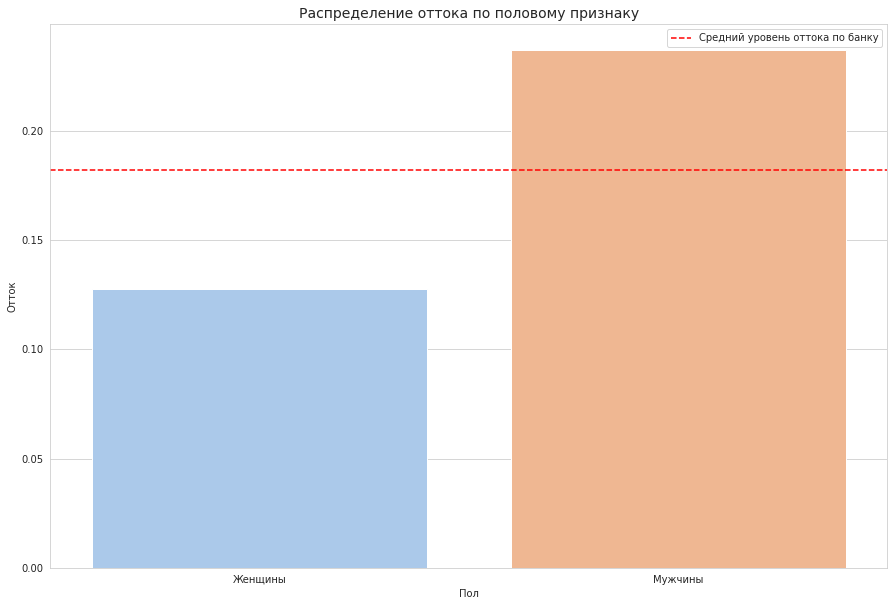

In [21]:
plt.figure(figsize=(15, 10))
sns.set_style('whitegrid')
sns.barplot(data=df, x='gender', y='churn', ci=None, palette='pastel')
plt.axhline(y=mean_churn, color='red', linestyle='--', label='Cредний уровень оттока по банку')
plt.xticks(ticks=[0, 1], labels=['Женщины', 'Мужчины'])
plt.title('Распределение оттока по половому признаку', fontsize=14)
plt.xlabel('Пол')
plt.ylabel('Отток')
plt.legend()
plt.show()

Отток мужчин из банка выше, чем средний отток по банку.

### Анализ оттока по количеству собственности

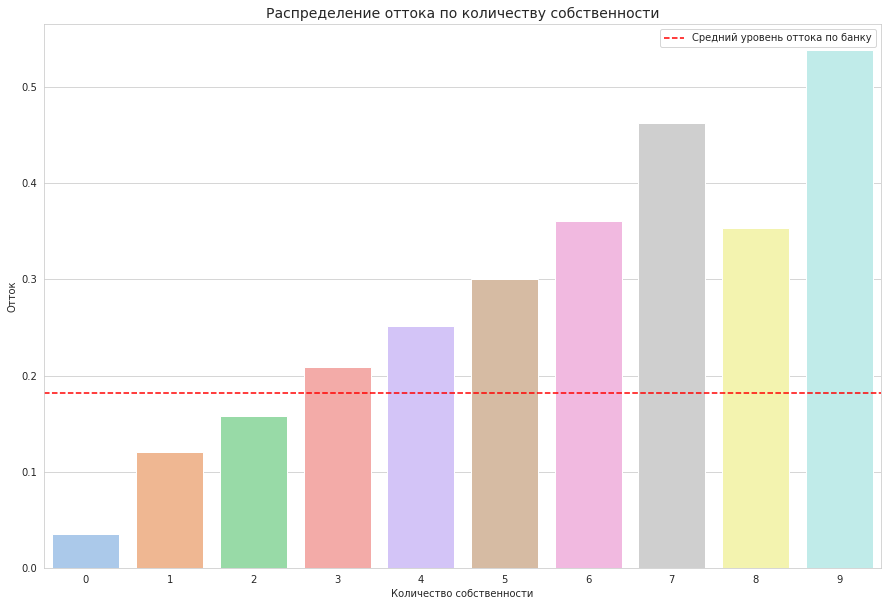

In [22]:
plt.figure(figsize=(15, 10))
sns.set_style('whitegrid')
sns.barplot(data=df, x='equity', y='churn', ci=None, palette='pastel')
plt.axhline(y=mean_churn, color='red', linestyle='--', label='Cредний уровень оттока по банку')
plt.title('Распределение оттока по количеству собственности', fontsize=14)
plt.xlabel('Количество собственности')
plt.ylabel('Отток')
plt.legend()
plt.show()

Клиенты имеющие 3 и более собственности склонны к оттоку из банка.

### Анализ оттока по количеству продуктов банка

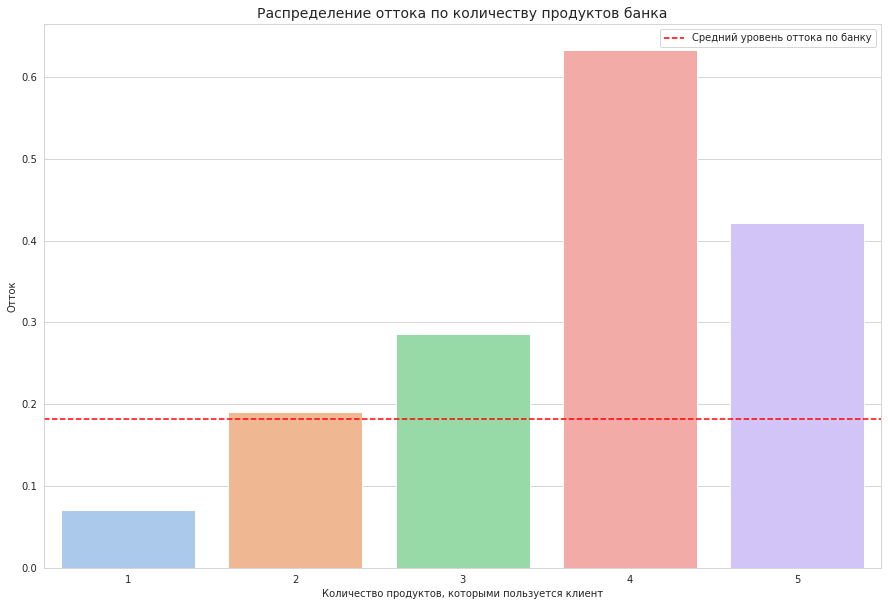

In [23]:
plt.figure(figsize=(15, 10))
sns.set_style('whitegrid')
sns.barplot(data=df, x='products', y='churn', ci=None, palette='pastel')
plt.axhline(y=mean_churn, color='red', linestyle='--', label='Cредний уровень оттока по банку')
plt.title('Распределение оттока по количеству продуктов банка', fontsize=14)
plt.xlabel('Количество продуктов, которыми пользуется клиент')
plt.ylabel('Отток')
plt.legend()
plt.show()

Клиенты, использующие больше одного продукта склонны к оттоку из банка.

### Анализ оттока по наличию кредитной карты

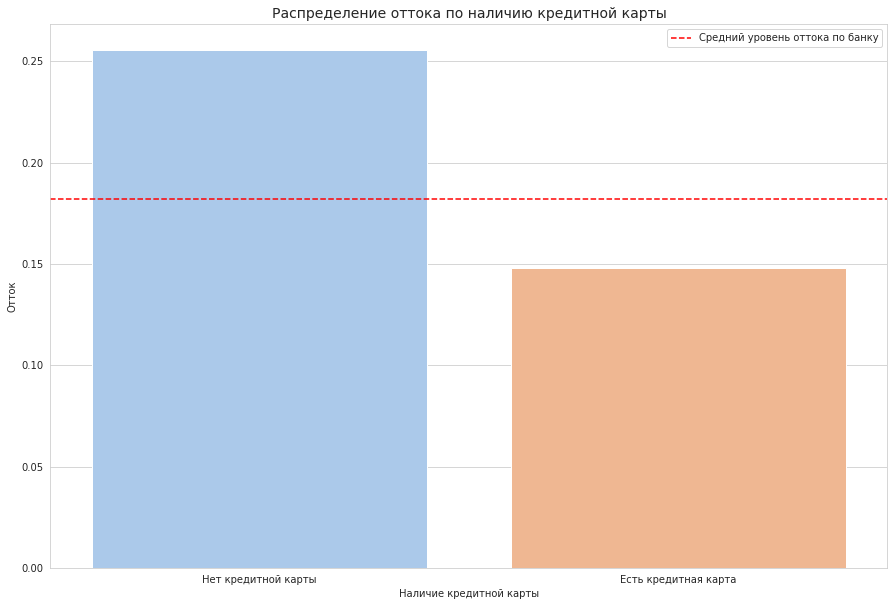

In [24]:
plt.figure(figsize=(15, 10))
sns.set_style('whitegrid')
sns.barplot(data=df, x='credit_card', y='churn', ci=None, palette='pastel')
plt.axhline(y=mean_churn, color='red', linestyle='--', label='Cредний уровень оттока по банку')
plt.xticks(ticks=[0, 1], labels=['Нет кредитной карты', 'Есть кредитная карта'])
plt.title('Распределение оттока по наличию кредитной карты', fontsize=14)
plt.xlabel('Наличие кредитной карты')
plt.ylabel('Отток')
plt.legend()
plt.show()

Отток клиентов, которые не имеют кредтную карту, превышает средний отток по банку.

### Анализ оттока по активности клиента

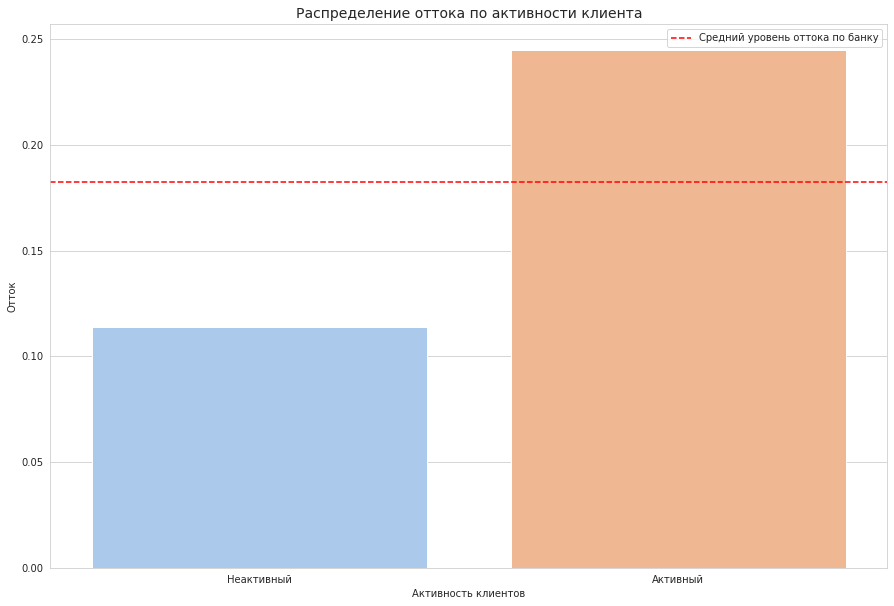

In [25]:
plt.figure(figsize=(15, 10))
sns.set_style('whitegrid')
sns.barplot(data=df, x='last_activity', y='churn', ci=None, palette='pastel')
plt.axhline(y=mean_churn, color='red', linestyle='--', label='Cредний уровень оттока по банку')
plt.xticks(ticks=[0, 1], labels=['Неактивный', 'Активный'])
plt.title('Распределение оттока по активности клиента', fontsize=14)
plt.xlabel('Активность клиентов')
plt.ylabel('Отток')
plt.legend()
plt.show()

Отток активных клиентов больше неактивных.

### Корреляционный анализ

In [26]:
# отберем признаки, между которыми будем смотреть зависимость
df_corr = df[['score', 'age', 'equity', 'balance', 'products', 'credit_card', 'last_activity', 'est_salary', 'Ростов', 'Рыбинск', 'Ярославль', 'gender_dum', 'churn']]
df_corr.head()

,score,age,equity,balance,products,credit_card,last_activity,est_salary,Ростов,Рыбинск,Ярославль,gender_dum,churn
0,850,25,1,59214.82,2,0,1,75719.14,0,1,0,0,1
1,861,37,5,850594.33,3,1,0,86621.77,0,1,0,0,0
2,892,30,0,NaN,1,1,1,107683.34,0,1,0,0,0
3,866,51,5,1524746.26,2,0,1,174423.53,0,0,1,0,1
4,730,34,5,174.00,1,1,0,67353.16,0,0,1,1,1


In [27]:
# построим матрицу корреляции признаков
df_corr.corr()

,score,age,equity,balance,products,credit_card,last_activity,est_salary,Ростов,Рыбинск,Ярославль,gender_dum,churn
score,1.000000,-0.012339,0.064787,0.235283,-0.003662,-0.095032,-0.030168,0.164350,-0.037508,-0.001076,0.027579,0.011406,0.106076
age,-0.012339,1.000000,0.020581,0.069745,0.017900,-0.122761,-0.007849,-0.039354,0.047128,0.028978,-0.059549,-0.212628,-0.050463
equity,0.064787,0.020581,1.000000,0.163793,0.431110,-0.167262,-0.001991,-0.171506,0.035372,-0.005004,-0.020583,-0.020798,0.270105
balance,0.235283,0.069745,0.163793,1.000000,0.075716,-0.059850,0.024770,0.338800,-0.035635,-0.034420,0.056967,0.051271,0.085915
products,-0.003662,0.017900,0.431110,0.075716,1.000000,-0.251562,0.037320,-0.117802,-0.006982,-0.041882,0.042698,-0.022375,0.301274
credit_card,-0.095032,-0.122761,-0.167262,-0.059850,-0.251562,1.000000,-0.033331,0.035883,-0.098073,-0.050134,0.114756,0.125961,-0.130122
last_activity,-0.030168,-0.007849,-0.001991,0.024770,0.037320,-0.033331,1.000000,0.002852,0.007222,0.048694,-0.049008,-0.013191,0.169690
est_salary,0.164350,-0.039354,-0.171506,0.338800,-0.117802,0.035883,0.002852,1.000000,-0.105964,-0.056535,0.126123,0.082491,0.001893
Ростов,-0.037508,0.047128,0.035372,-0.035635,-0.006982,-0.098073,0.007222,-0.105964,1.000000,-0.246721,-0.487067,-0.014731,0.005115
Рыбинск,-0.001076,0.028978,-0.005004,-0.034420,-0.041882,-0.050134,0.048694,-0.056535,-0.246721,1.000000,-0.726196,-0.015020,-0.030989


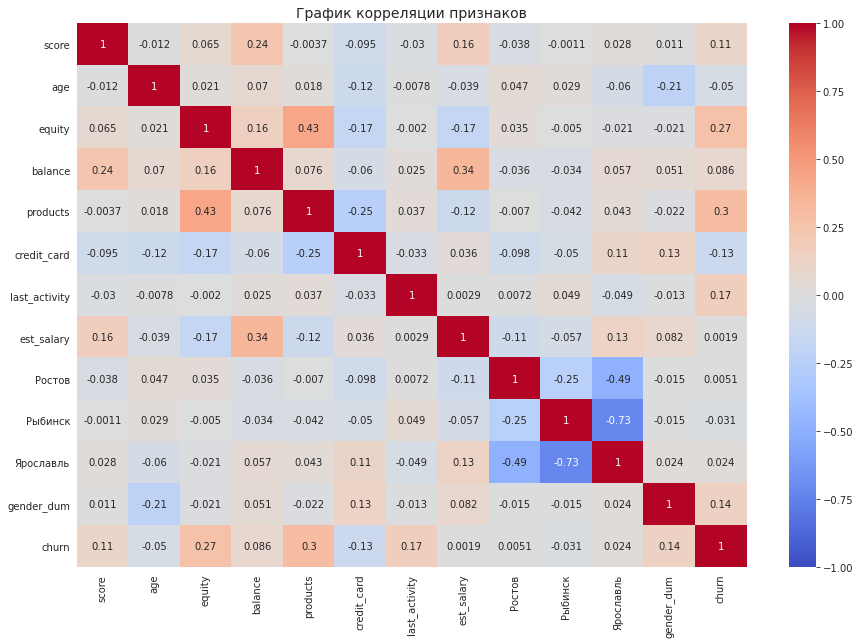

In [28]:
# визуализируем корреляцию при помощи тепловой карты
plt.figure(figsize=(15, 10))
sns.set_style('whitegrid')
sns.heatmap(df_corr.corr(), cmap='coolwarm', center=0, vmin=-1, vmax=1, annot=True)
plt.title('График корреляции признаков', fontsize=14)
plt.show()

Анализируя зависимость коэффициентов корреляции по шкале Чеддока, наблюдается слабая связь (0,1 - 0,3) признака оттока с такими признаками как: 
- баллы кредитного скоринга, 
- пол, 
- наличие кредитной карты, 
- активность клиента, 
- количество баллов собственности,
- количество продуктов, которыми пользуется клиент.

Корреляционная зависимость остальных признаков с оттоком клиентов практически отсутствует.

### Cравненине портретов клиентов, которые склонны и не склонны уходить из банка

На основании проведенного анализа, составим портреты клиентов, которые склонны и не склонны уходить из банка:


|                               | **Возраст**       | **Пол** | **Cкоринг**| **Собственность**| **Продукты**| **Кредитная карта** | **Баланс на счёте** |
|:------------------------------|:------------------|:--------|:-----------|:-----------------|:------------|:-----|:--------|
|**Клиент, склонный уходить**   | 25-36, 50-61      | мужчина | 820-900    | 3 и более        | 2 и более   | нет  | > 1 млн.|
|**Клиент, не склонный уходить**| 18-24, 37-49, >62 | женщина | <819, >942 | от 0 до 3        | 1           | есть | < 750 тыс.|


## Проверка статистических гипотез

### Проверка гипотезы различия дохода между теми клиентами, которые ушли и теми, которые остались

- **Нулевая гипотеза:** доходы клиентов, которые ушли и остались, равны.
- **Альтернативная гипотеза:** доходы клиентов, которые ушли и остались, неравны.

In [29]:
# Подготовим данные
df_churn = df.query('churn == 1')
df_not_churn = df.query('churn == 0')

In [30]:
# Проверим размеры выборок
display(df_churn['est_salary'].shape[0])
df_not_churn['est_salary'].shape[0]

1818

8155

Размеры наших выборок очень отличаются, поэтому если будем использовать t-test Стьюдента, то необходимо будет ввести параметр equal_var='False'. Но для начала проверим наши выборки на нормальность.

In [31]:
# напишем функцию проверки распределения на нормальность с использованием критерия Шапиро-Уилка
def shapiro(data):
    alpha = 0.05  # критический уровень статистической значимости
    results = st.shapiro(data)
    p_value = results[1] 
    
    print('p-значение: ', p_value)
    
    if p_value < alpha:
        print('Отвергаем нулевую гипотезу: распределение не нормально')
    else:
        print('Не получилось отвергнуть нулевую гипотезу, всё нормально')

In [32]:
# проверим нормальность распределения доходов клиентов, которые ушли
shapiro(df_churn['est_salary'])

p-значение:  0.0
Отвергаем нулевую гипотезу: распределение не нормально


In [33]:
# проверим нормальность распределения доходов клиентов, которые остались
shapiro(df_not_churn['est_salary'])

p-значение:  0.0
Отвергаем нулевую гипотезу: распределение не нормально


/opt/conda/lib/python3.9/site-packages/scipy/stats/_morestats.py:1800: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Т.к. после проверки тестом Шапиро-Уилка данных на соответствие нормальному распределению, мы выяснили что наши распределения не нормальны. Поэтому мы не можем использовать t-test Стьюдента и в данном случае будем использовать непараметрический u-критерий Манна-Уитни.

In [34]:
# проверим статистическую значимость гипотез непараметрическим тестом Уилкоксона-Манна-Уитни
alpha = 0.05
results = st.mannwhitneyu(df_churn['est_salary'], df_not_churn['est_salary'], True)

print('p-значение: ', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу: разница статистически значима')
else:
    print('Не получилось отвергнуть нулевую гипотезу, вывод о различии сделать нельзя')

p-значение:  0.00016830729188229058
Отвергаем нулевую гипотезу: разница статистически значима


**Вывод:** Отвергаем нулевую гипотезу, значит нет основания считать, что доходы клиентов, которые ушли и остались, равны.

### Проверка гипотезы различия балла кредитного скоринга между теми клиентами, которые ушли и теми, которые остались

In [35]:
# проверим нормальность распределения балла кредитного скоринга клиентов, которые ушли
shapiro(df_churn['score'])

p-значение:  9.341003897134215e-05
Отвергаем нулевую гипотезу: распределение не нормально


In [36]:
# проверим нормальность распределения балла кредитного скоринга клиентов, которые остались
shapiro(df_not_churn['score'])

p-значение:  6.163534187648631e-26
Отвергаем нулевую гипотезу: распределение не нормально


In [37]:
# проверим статистическую значимость гипотез непараметрическим тестом Уилкоксона-Манна-Уитни
alpha = 0.05
results = st.mannwhitneyu(df_churn['score'], df_not_churn['score'], True)

print('p-значение: ', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу: разница статистически значима')
else:
    print('Не получилось отвергнуть нулевую гипотезу, вывод о различии сделать нельзя')

p-значение:  4.508763537702903e-22
Отвергаем нулевую гипотезу: разница статистически значима


**Вывод:** Отвергаем нулевую гипотезу, значит нет основания считать, что баллы кредитного скоринга клиентов, которые ушли и остались, равны.

## Подведение промежуточных итогов

На основе EDA и корреляционного анализа мы выбрали следующие признаки:
- количество продуктов - больше 1,
- количество баллов собственности - больше 2,
- активность клиента - активные,
- пол - мужчины,
- баллы кредитного скоринга - 820-900,
- баланс на счете - больше 1 млн.,
- возраст - 25-36, 50-61.

 Из этих признаков мы составим сегменты клиентов, которые наиболее подвержены оттоку.

Также при проверке гипотез о равенстве доходов и баллов скоринга между отточными клиентами и теми клиентами, которые остались, мы выявили, что данные признаки выборок неравны, а значит могут оказывать влияние на отток клиентов.


## Сегментация

На основе анализа корреляции признаков с признаком оттока, мы выделили те признаки, которые коррелируют больше. На основе этих признаков выделим сегменты клиентов с уровнем оттока выше среднего по банку 18%.

### Сегмент 1 (Взрослые мужчины)

Для первого сегмента выберем следующие признаки:
- пол - мужчины
- возраст - от 50 до 61

In [38]:
segment_1 = df.query('gender_dum == 1 and (50 <= age <= 61)')

In [39]:
display(f'Количество клиентов в сегменте: {segment_1.shape[0]}')
display(f'Количество отточных клиентов в сегменте: {segment_1.query("churn == 1").shape[0]}')
'Уровень оттока в сегменте: {:.0%}'.format(segment_1["churn"].mean())

'Количество клиентов в сегменте: 819'

'Количество отточных клиентов в сегменте: 267'

'Уровень оттока в сегменте: 33%'

### Сегмент 2 (Обеспеченные клиенты)

Для второго сегмента выберем следующие признаки:
- количество собственности - больше 2
- баланс на счете - больше 1000000
- балл кредитного скоринга - от 820 до 900

In [40]:
segment_2 = df.query('equity >= 3 and balance > 1000000 and (820 <= score <= 900)')

In [41]:
display(f'Количество клиентов в сегменте: {segment_2.shape[0]}')
display(f'Количество отточных клиентов в сегменте: {segment_2.query("churn == 1").shape[0]}')
'Уровень оттока в сегменте: {:.0%}'.format(segment_2["churn"].mean())

'Количество клиентов в сегменте: 741'

'Количество отточных клиентов в сегменте: 322'

'Уровень оттока в сегменте: 43%'

### Сегмент 3 (Молодые активные клиенты со средним доходом)

Для третьего сегмента выберем следующие признаки:
- возраст - от 25 до 36
- активный клиент - 1 (да)
- доход - от 90 тыс. до 210 тыс.

In [42]:
segment_3 = df.query('(90000 <= est_salary <= 210000) and (25 <= age <= 36) and last_activity == 1')

In [43]:
display(f'Количество клиентов в сегменте: {segment_3.shape[0]}')
display(f'Количество отточных клиентов в сегменте: {segment_3.query("churn == 1").shape[0]}')
'Уровень оттока в сегменте: {:.0%}'.format(segment_3["churn"].mean())

'Количество клиентов в сегменте: 889'

'Количество отточных клиентов в сегменте: 321'

'Уровень оттока в сегменте: 36%'

## Приоритизация сегментов

Приоритизируем сегменты по уровню оттока:<br>
1) Сегмент 2 (Обеспеченные клиенты) - 43%<br>
2) Сегмент 3 (Молодые активные клиенты со средним доходом) - 36%<br>
3) Сегмент 1 (Взрослые мужчины) - 33%<br>

## Рекомендации

Для **сегмента 2** (Обеспеченные клиенты):
- предложить открытие вклада на сумму от 1 млн. с увеличенной процентной ставкой
- льготное страхование имущества при оформлении ипотеки в банке
- предложить бесплатную консультацию по инвестированию при открытии инвестиционного счета

Для **сегмента 3** (Молодые активные клиенты со средним доходом):
- предложить акцию "приведи друга" и получи кэшбэк
- предложить овердрафт для дебетовой карты
- кэшбэк за оплату покупок на маркетплейсах

Для **сегмента 1** (Взрослые мужчины):
- увеличенный кэшбэк за оплату на АЗС, в сервисах, в автомагазинах
- при открытии долгосрочного вклада для прибавки к пенсии банк начисляет дополнительные проценты
- кэшбэк за оплату услуг ЖКУ